<a href="https://colab.research.google.com/github/ShaanHossain/NLPFinalProject/blob/master/Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
# from google.colab import drive # import drive from google colab
# ROOT = "/content/drive"     # default location for the drive
# print(ROOT)                 # print content of ROOT (Optional
# drive.mount(ROOT)           # we mount the google drive at /content/drive

# 1. Importing Dependencies

In [2]:
#import files
import sys
from csv import reader
from typing import List
from nltk.tokenize import RegexpTokenizer
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation
import numpy as np
import inflect
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 2. Initial Setup - Defining the driving variables

In [3]:
# Determines which dataset use and how much to use :
# HateSpeech: Column-0 : Sentence, Column-1 : Label [noHate-0, Hate-1]
# either 'HateSpeech' or 'KaggleTwitter' or 'TDavidson'
dataset_to_use = "HateSpeech"
dataset_percentage = 100  # percentage range 1 to 100

# Initializes file path, column of csv file to parse and
# the delimiter for parsing
training_file = ""
test_file = ""
sentence_column_to_parse = None
label_column_to_parse = None
lancaster = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
delimiter = ","
if dataset_to_use == "HateSpeech":
    training_file = "datasets/hate-speech/train.txt"
    test_file = "datasets/hate-speech/test.txt"
    delimiter = "\t"
    sentence_column_to_parse = 0
    label_column_to_parse = 1
elif dataset_to_use == "KaggleTwitter":
    training_file = "datasets/kaggle-twitter/train.csv"
    test_file = "datasets/kaggle-twitter/test.csv"
    sentence_column_to_parse = 2
    label_column_to_parse = 1
elif dataset_to_use == "TDavidson":
    training_file = "datasets/t-davidson-hate-speech/labeled_data.csv"
    # TODO: Update test path for this dataset
    # test_file = "datasets/kaggle-twitter/test.csv"
    sentence_column_to_parse = 6
    label_column_to_parse = 2
else:
    print("Invalid Dataset specified")
    sys.exit(1)

# 1. Preprocessing the Data

### Seven tasks are done as part of this:
  - lower word case
  - remove stopwords
  - remove punctuation
  - convert numbers to texts
  - perform stemming
  - Add - \<s> and \</s> for every sentence

In [4]:
def replace_numbers(sentence:List[str]) -> List[str]:
    """Replace all interger occurrences in list of tokenized words
    with textual representation"""
    p = inflect.engine()
    new_words = []  
    for word in sentence.split():
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return " ".join(new_words)

def stem_words(sentence: List[str]) -> List[str]:
    """Stems the given sentence

    Args:
        sentence (list): words to be stemmed

    Returns:
        str: stemmed sentence
    """
    stemmed_words = []
    for word in sentence.split():
        stemmed_words.append(lancaster.stem(word))
    return " ".join(stemmed_words)

def preprocessing(running_lines: List[str]) -> List[str]:
    """This function takes in the running test and return back the
    preprocessed text. Six tasks are done as part of this:
      1. lower word case
      2. remove stopwords
      3. remove punctuation
      4. convert numbers to texts
      5. perform stemming

    Args:
        sentence (List[str]): list of lines

    Returns:
        List[str]: list of sentences which are processed
    """
    preprocessed_lines = []
    tokenizer = RegexpTokenizer(r"\w+")
    for line in running_lines:
        # lower case
        lower_case_data = line.lower()
        # remove stop words
        data_without_stop_word = remove_stopwords(lower_case_data)
        # remove punctunation
        data_without_punct = strip_punctuation(data_without_stop_word)
        # replace numbers '1' to 'one'
        processed_data = replace_numbers(data_without_punct)
        # stem words
        processed_data = stem_words(processed_data)
        # add start and stop tags
        # processed_data.insert(0, "<s>")
        # processed_data.append("</s>")
        preprocessed_lines.append(processed_data)
    return preprocessed_lines

# 2. Parsing the data

In [5]:
def parse_data(training_file_path: str, percentage: int,
               sentence_column: int, label_column: int,
               delimit: str):
    """This function is used to parse input lines
    and returns a the provided percent of data.

    Args:
        lines (List[str]): list of lines
        percentage (int): percent of the dataset needed
        sentence_column (int): sentence column from the dataset
        label_column (int): label column from the dataset
        delimit (str): delimiter
    Returns:
        List[str], List[str]: examples , labels -> [percentage of dataset]
    """
    percentage_sentences = []
    percentage_labels = []
    with open(training_file_path, "r", encoding="utf8",
              errors="ignore") as csvfile:
        read_sentences = []
        label_sentences = []
        csv_reader = reader(csvfile, delimiter=delimit)
        # skipping header
        header = next(csv_reader)
        # line_length = len(list(csv_reader_copy))
        if header is not None:
            for row in csv_reader:
                read_sentences.append(row[sentence_column])
                label_sentences.append(int(row[label_column]))
        end_of_data = int(len(read_sentences) * percentage * .01)
        percentage_sentences = read_sentences[0:end_of_data]
        percentage_labels = label_sentences[0:end_of_data]
    return percentage_sentences, percentage_labels

In [6]:
train_sentences, train_labels = parse_data(training_file,
                                           dataset_percentage,
                                           sentence_column_to_parse,
                                           label_column_to_parse,
                                           delimiter)
# parse and preprocess the data
processed_train_sentences = preprocessing(train_sentences)
# verify the processed sentences
# for sentence in sentences:
#     print(sentence)
# This is the baseline classifier
print(
    f"Performing Improved - BiLSTM on {dataset_to_use}"
    f" with {dataset_percentage} % data ")

Performing Improved - BiLSTM on HateSpeech with 100 % data 


# 3. Building Model

### 3.1 Generating word embeddings

For this step, we intend to use the Keras library to build a recurrent neural network based on bidirectional LSTMs. The model will take word embeddings as input so we will use pre-trained GloVe embeddings to make the embedding dictionary.

In [7]:
def convert_sentence_word_embeddings(X_train_sentences:List[str]):
    """Converts the sentences into word embeddings.

    Args:
        X_train_sentences (List[str]): list of training sentences

    Returns:
        tuple: word embeddings for each sentence, vocab size and embedding dictionary
    """
    tokenizer = Tokenizer()
    text = np.array(X_train_sentences)
    tokenizer.fit_on_texts(X_train_sentences)
    # pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    # Uncomment above line to save the tokenizer as .pkl file 
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    embeddings_dict = {}
    file_embeddings = open("utils/glove.twitter.27B.50d.txt", encoding="utf8")
    for embedding_line in file_embeddings:
        values = embedding_line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs
    file_embeddings.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (text, word_index, embeddings_dict)

In [8]:
X_train_Glove_s, word_index_s, embeddings_dict_s = convert_sentence_word_embeddings(processed_train_sentences)
embedding_size = len(X_train_Glove_s[0])
## Check function
# x_train_sample = ["Lorem Ipsum is simply dummy text of the printing and typesetting industry", "It is a long established fact that a reader will be distracted by the readable content of a page when looking at its layout"]
# X_train_Glove_s, word_index_s, embeddings_dict_s = convert_sentence_word_embeddings(x_train_sample)
# print("\n X_train_Glove_s \n ", X_train_Glove_s)
# print("\n Word index of the word testing is : ", word_index_s["industry"])
# print("\n Embedding for thw word want \n \n", embeddings_dict_s["want"])

Found 3951 unique tokens.
Total 1193514 word vectors.


### 3.2 Defining function to create model

In [9]:
from keras.models import Sequential
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
def build_bilstm(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    model = Sequential()
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))
    # Add hidden layers 
    for i in range(0,hidden_layer):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(lstm_node, return_sequences=True, recurrent_dropout=0.2)))
        # Add a dropout layer after each lstm layer
        model.add(Dropout(dropout))
    model.add(Bidirectional(LSTM(lstm_node, recurrent_dropout=0.2)))
    model.add(Dropout(dropout))
    # Add the fully connected layer with 256 nurons and relu activation
    model.add(Dense(256, activation='relu'))
    # Add the output layer with softmax activation since we have 2 classes
    model.add(Dense(nclasses, activation='softmax'))
    # Compile the model using sparse_categorical_crossentropy
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
    return model

In [12]:
print("Building Model!")
model = build_bilstm(word_index_s, embeddings_dict_s, 2, embedding_size)
model.summary()

Building Model!


2021-12-08 12:45:25.998784: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 143, 50)           197600    
                                                                 
 bidirectional (Bidirectiona  (None, 143, 64)          21248     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 143, 64)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 143, 64)          24832     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 143, 64)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 143, 64)          2

Epoch 1/5
12/12 [==============================] - 17s 564ms/step - loss: 0.6933 - accuracy: 0.5183 - val_loss: 0.6809 - val_accuracy: 0.5483
Epoch 2/5
12/12 [==============================] - 6s 469ms/step - loss: 0.6736 - accuracy: 0.5961 - val_loss: 0.6625 - val_accuracy: 0.5979
Epoch 3/5
12/12 [==============================] - 6s 536ms/step - loss: 0.6399 - accuracy: 0.6307 - val_loss: 0.6508 - val_accuracy: 0.6110
Epoch 4/5
12/12 [==============================] - 6s 521ms/step - loss: 0.5968 - accuracy: 0.6876 - val_loss: 0.6755 - val_accuracy: 0.6475
Epoch 5/5
12/12 [==============================] - 6s 470ms/step - loss: 0.5554 - accuracy: 0.7196 - val_loss: 0.6011 - val_accuracy: 0.6449


AttributeError: 'AxesSubplot' object has no attribute 'xlabel'

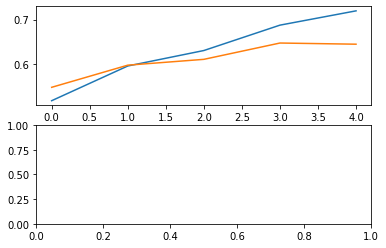

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_train_Glove_s, train_labels, test_size = 0.2)
data_history = model.fit(np.array(X_train), np.array(y_train),
                           validation_data=(np.array(X_test),np.array(y_test)),
                           epochs=5,
                           batch_size=128,
                           verbose=1)

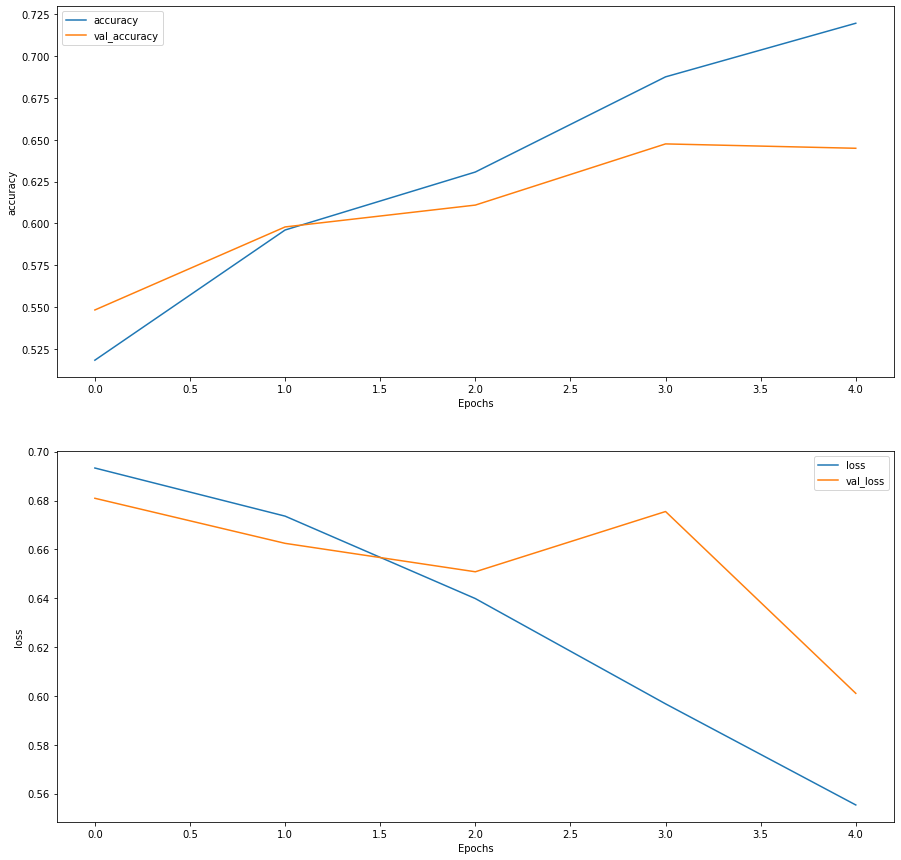

In [19]:
def plot_graphs(axs, graph_index, history, string):
    axs[graph_index].plot(history.history[string])
    axs[graph_index].plot(history.history['val_'+string], '')
    # axs[graph_index].xlabel("Epochs")
    # axs[graph_index].ylabel(string)
    axs[graph_index].set(xlabel="Epochs", ylabel=string)
    axs[graph_index].legend([string, 'val_'+string])
    # axs[graph_index].show()

fig, axs = plt.subplots(2, figsize=(15, 15))
                        
plot_graphs(axs, 0, data_history, 'accuracy')
plot_graphs(axs, 1, data_history, 'loss')